# Survival Analysis for Customer Churn

- [Dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data)
- [Dataset-Legend](https://community.ibm.com/community/user/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)
- [lifelines package](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html)
- [kaggle](https://www.kaggle.com/code/bryanb/survival-analysis-with-cox-model-implementation#The-Kaplan-Meier-Estimator)
- [kaggle2](https://www.kaggle.com/code/gunesevitan/survival-analysis/notebook#Survival-Analysis)
- [Medium: XGBoost for Survival Analysis](https://towardsdatascience.com/xgbse-improving-xgboost-for-survival-analysis-393d47f1384a)
- [PySurvival](https://square.github.io/pysurvival/intro.html)
- [Future Developement: Deep-Learning for Survival Analysis](https://www.kaggle.com/code/louise2001/deep-learning-for-survival-analysis/comments)

## Theory

### Concepts

- Survival analysis is a branch of statistics used to analyze the expected duration of time until one or more events happen, such as death in biological organisms and failure in mechanical systems.
- In the context of customer churn analysis, the "event" typically refers to a customer ending their relationship with a company.

- Key Concepts in Survival Analysis:
    - **Survival Function**: This estimates the probability that a customer will "survive" (not churn) up to a certain point in time.
    - **Hazard Function**: This estimates the instantaneous rate at which customers are churning at a specific time, given that they have "survived" up to that time.
    - **Censoring**: This occurs when we have incomplete information about a customer's tenure with the company (e.g., they are still active customers at the time of analysis).

### Types of Survival Models

- **Non-Parametric Models**
    - Do not assume a specific distribution for survival times.
    - Examples:
        - **Kaplan-Meier Estimator:** Estimates the survival function.
        - **Log-Rank Test:** Compares survival curves between groups.
- **Semi-Parametric Models**
    - Combine parametric and non-parametric elements.
    - Example:
        - **Cox Proportional Hazards Model:** Models the hazard function without assuming a specific baseline hazard distribution.
- **Parametric Models**
    - Assume a specific distribution for survival times.
    - Examples:
        - **Exponential Model**
        - **Weibull Model**
        - **Log-Normal Model**

## Data Preparation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
from lifelines import KaplanMeierFitter, CoxPHFitter

from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import xgboost as xgb

In [3]:
from survival.Survival import Survival
from survival.plot import PlotlySurvival

from hazard.Hazard import HazardReport, get_aucs_scores
from hazard.plot import PlotlyHazard

from utils import get_groups_pct_survive, get_groups_pct_survives

In [4]:
import plotly.io as pio
import plotly.graph_objects as go

custom_template = go.layout.Template(
    layout=go.Layout(
        # font=dict(family="Arial", size=14, color="black"),
        title=dict(font=dict(size=20, color="darkblue"), x=0.5, xanchor='center'),        
    )
)
pio.templates["my_custom"] = custom_template  # Register template
pio.templates.default = "plotly_white+my_custom"  # Set as default

In [5]:
df = pd.read_csv('telco_customer_churn_clean.csv', index_col=0)
df['Churn'] = df['Churn'].astype(bool)
df.head()

Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
customerID                                                                  
7590-VHVEG  Female              0     Yes         No       1           No   
5575-GNVDE    Male              0      No         No      34          Yes   
3668-QPYBK    Male              0      No         No       2          Yes   
7795-CFOCW    Male              0      No         No      45           No   
9237-HQITU  Female              0      No         No       2          Yes   

               MultipleLines InternetService OnlineSecurity OnlineBackup  \
customerID                                                                 
7590-VHVEG  No phone service             DSL             No          Yes   
5575-GNVDE                No             DSL            Yes           No   
3668-QPYBK                No             DSL            Yes          Yes   
7795-CFOCW  No phone service             DSL            Yes           No   
9237-HQITU                No     Fiber optic             No           No   

           DeviceProtection TechSupport StreamingTV StreamingMovies  \
customerID                                                            
7590-VHVEG               No          No          No              No   
5575-GNVDE              Yes          No          No              No   
3668-QPYBK               No          No          No              No   
7795-CFOCW              Yes         Yes          No              No   
9237-HQITU               No          No          No              No   

                  Contract PaperlessBilling              PaymentMethod  \
customerID                                                               
7590-VHVEG  Month-to-month              Yes           Electronic check   
5575-GNVDE        One year               No               Mailed check   
3668-QPYBK  Month-to-month              Yes               Mailed check   
7795-CFOCW        One year               No  Bank transfer (automatic)   
9237-HQITU  Month-to-month              Yes           Electronic check   

            MonthlyCharges  TotalCharges  Churn  
customerID                                       
7590-VHVEG           29.85         29.85  False  
5575-GNVDE           56.95       1889.50  False  
3668-QPYBK           53.85        108.15   True  
7795-CFOCW           42.30       1840.75  False  
9237-HQITU           70.70        151.65   True

## EDA

### Churn Compositions

In [6]:
pd.concat([
    df.dtypes.rename('Dtype'), 
    df.isna().sum().rename('Missing Value'), 
    df.nunique().rename('Num. of Unique Value'), 
    df.apply(lambda x: set(x)).rename('Unique Value')
], axis=1)

Dtype  Missing Value  Num. of Unique Value  \
Gender             object              0                     2   
SeniorCitizen       int64              0                     2   
Partner            object              0                     2   
Dependents         object              0                     2   
Tenure              int64              0                    73   
PhoneService       object              0                     2   
MultipleLines      object              0                     3   
InternetService    object              0                     3   
OnlineSecurity     object              0                     3   
OnlineBackup       object              0                     3   
DeviceProtection   object              0                     3   
TechSupport        object              0                     3   
StreamingTV        object              0                     3   
StreamingMovies    object              0                     3   
Contract           object              0                     3   
PaperlessBilling   object              0                     2   
PaymentMethod      object              0                     4   
MonthlyCharges    float64              0                  1585   
TotalCharges      float64              0                  6531   
Churn                bool              0                     2   

                                                       Unique Value  
Gender                                               {Female, Male}  
SeniorCitizen                                                {0, 1}  
Partner                                                   {No, Yes}  
Dependents                                                {No, Yes}  
Tenure            {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
PhoneService                                              {No, Yes}  
MultipleLines                           {No, No phone service, Yes}  
InternetService                              {Fiber optic, DSL, No}  
OnlineSecurity                       {No, No internet service, Yes}  
OnlineBackup                         {No, No internet service, Yes}  
DeviceProtection                     {No, No internet service, Yes}  
TechSupport                          {No, No internet service, Yes}  
StreamingTV                          {No, No internet service, Yes}  
StreamingMovies                      {No, No internet service, Yes}  
Contract                       {One year, Month-to-month, Two year}  
PaperlessBilling                                          {No, Yes}  
PaymentMethod     {Electronic check, Mailed check, Bank transfer...  
MonthlyCharges    {18.95, 19.8, 20.65, 20.15, 20.2, 20.75, 24.95...  
TotalCharges      {19.75, 20.75, 20.25, 19.25, 19.0, 20.0, 25.25...  
Churn                                                 {False, True}

In [7]:
churn_valcounts = df['Churn'].value_counts().reset_index()
churn_valcounts['percentage'] = (churn_valcounts['count'] / len(df) * 100).round(2)
churn_valcounts['variable'] = 'Churn'

In [8]:
fig_bar = px.bar(churn_valcounts, y='count', x='variable', color='Churn', text='percentage', text_auto=True)
fig_bar.update_layout(    
    yaxis=dict(title='', showticklabels=False, range=[0, 7000]),
    xaxis=dict(title='', showticklabels=False),
    title=dict(text='Churn Composition', x=0.5, xanchor='center'),			
    height=420,
    legend=dict(x=0.5, xanchor='center', y=0, orientation='h', title='')			
).update_traces(hovertemplate='%{text}%')

In [9]:
fig_pie = px.pie(churn_valcounts, names='Churn', values='count', hole=0.3)
fig_pie.update_layout(
    legend=dict(x=0.5, xanchor='center', y=0, orientation='h', traceorder='reversed'),
    title_text='Churn Composition'
)

### Churn Across Different Tenure Periods

In [10]:
churn_counts = df.groupby(['Tenure', 'Churn']).size().unstack().melt(ignore_index=False).reset_index()
fig_churn_counts = px.histogram(churn_counts, y='value', x='Tenure', color='Churn', barnorm=None, nbins=churn_counts['Tenure'].nunique(), text_auto=True)
fig_churn_counts.update_layout(legend_traceorder='reversed', barcornerradius=15, bargap=0.1)

### Churn Correlations

In [11]:
df_corr = pd.get_dummies(df, prefix_sep=' | ').corr()
df_corr = df_corr['Churn'].sort_values()
df_corr = df_corr.drop('Churn').reset_index().round(3)
df_corr['variable'] = df_corr['index'].map(lambda x: x.split(' | ')[0])
df_corr = df_corr.rename({'index': 'variable-value'}, axis=1)

In [12]:
fig_bar = px.bar(df_corr, x='variable-value', y='Churn', color='Churn', text_auto=True, height=600)
fig_bar.update_layout(yaxis_title='Correlation', barcornerradius=15, title='Churn Correlations')

In [13]:
fig_group_bar = px.bar(df_corr, x='variable-value', y='Churn', color='variable', text_auto=True, height=600)
fig_group_bar.update_layout(title='Churn Correlations (Grouped)', yaxis_title='Correlation', barcornerradius=15)

## Survival Function (The Kaplan Meier Estimator)

What is the estimated probability that an individual survives beyond a certain time?

### Concepts

<b>Definition</b>: <br>
The survival function 𝑆(𝑡) gives the probability that an individual will survive (or not experience the event of interest) beyond time 𝑡: <br>
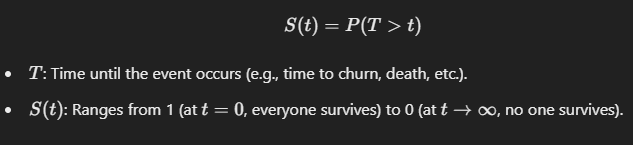
- Questions It Answers:
    1. What is the probability of surviving beyond a specific time 𝑡?
         - Example: What is the probability that a customer remains active after 6 months?
    2. How does survival probability change over time?
        - The survival curve provides a complete picture of survival rates over time.
- Purpose:
    1. The survival function focuses on absolute probabilities of survival over time.
    2. It gives time-dependent insights, showing how the risk of experiencing the event accumulates as time progresses.


### Example

#### Model Initialization and Fitting

In [14]:
kmf_all = KaplanMeierFitter()
kmf_all.fit(df['Tenure'], event_observed=df['Churn'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7043 total observations, 5174 right-censored observations>

In [15]:
kmf_all.event_table

removed  observed  censored  entrance  at_risk
event_at                                                
0.0            11         0        11      7043     7043
1.0           613       380       233         0     7032
2.0           238       123       115         0     6419
3.0           200        94       106         0     6181
4.0           176        83        93         0     5981
...           ...       ...       ...       ...      ...
68.0          100         9        91         0      846
69.0           95         8        87         0      746
70.0          119        11       108         0      651
71.0          170         6       164         0      532
72.0          362         6       356         0      362

[73 rows x 5 columns]

#### Probability of an Event Not Occurring Over a Period of Time (Customer Survival)

In [16]:
# A DataFrame showing the survival probability 
df_probs_alive = pd.concat([kmf_all.survival_function_, kmf_all.confidence_interval_], axis=1)
df_probs_alive.head()

KM_estimate  KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.0     1.000000                1.000000                1.000000
1.0     0.945961                0.940418                0.951002
2.0     0.927835                0.921506                0.933672
3.0     0.913725                0.906857                0.920108
4.0     0.901045                0.893733                0.907879

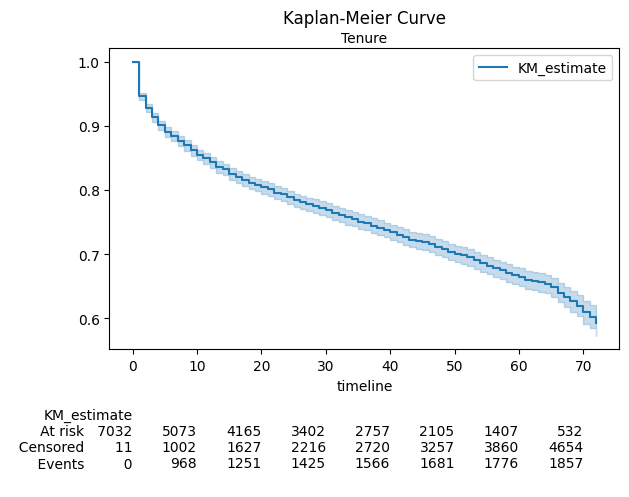

In [17]:
# Plot the curve and assign labels
kmf_all.plot(at_risk_counts=True)
plt.ylabel('Probability of Customer Survival')
plt.xlabel('Tenure')
plt.title('Kaplan-Meier Curve');

In [18]:
# Probability of customers remaining active and engaged with the business in 1 year (tenure=12)
df_probs_alive.loc[12]

KM_estimate               0.843200
KM_estimate_lower_0.95    0.834169
KM_estimate_upper_0.95    0.851783
Name: 12.0, dtype: float64

#### Probability of an Event Occurring Over a Period of Time (Customer Churn)

In [19]:
# Represents the probability that the event has occurred by time 
df_risk_churned = pd.concat([kmf_all.cumulative_density_ , kmf_all.confidence_interval_cumulative_density_], axis=1)
df_risk_churned.head()

KM_estimate  KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.0     0.000000                0.000000                0.000000
1.0     0.054039                0.048998                0.059582
2.0     0.072165                0.066328                0.078494
3.0     0.086275                0.079892                0.093143
4.0     0.098955                0.092121                0.106267

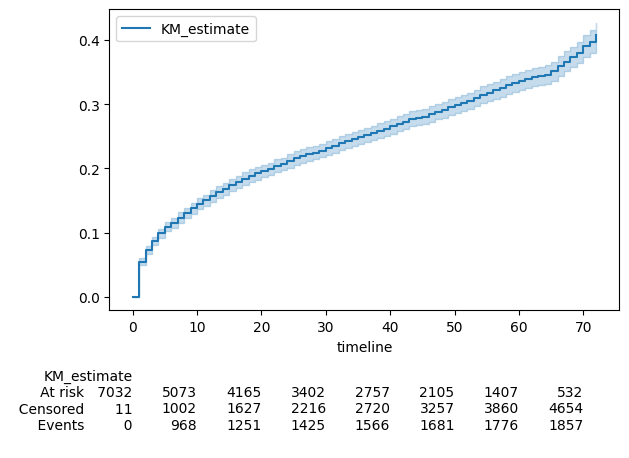

In [20]:
kmf_all.plot_cumulative_density(at_risk_counts=True);

In [21]:
# Probability of customers leaving in 1 year (tenure=12)
df_risk_churned.loc[12]

KM_estimate               0.156800
KM_estimate_lower_0.95    0.148217
KM_estimate_upper_0.95    0.165831
Name: 12.0, dtype: float64

### Survival Probability for All Customers

In [22]:
MySurvival = Survival(df, 'Tenure', 'Churn')

In [23]:
df_prob, df_ci = MySurvival.get_survival_function(confidence_interval=True)

In [24]:
df_prob['lower'] = df_prob['Survival'] - df_ci['Survival_lower_0.95']
df_prob['upper'] = df_ci['Survival_upper_0.95'] - df_prob['Survival']

In [25]:
PlotlySurvival.plot_survival_curve(df_prob, 'upper', 'lower')

In [26]:
df_prob['Survival'].pct_change().abs().max(), df_prob['Survival'].pct_change().abs().argmax()

(np.float64(0.05403868031854342), np.int64(1))

In [27]:
df_prob['Survival'].pct_change().abs().min(), df_prob['Survival'].pct_change().abs().argmin()

(np.float64(0.002346499804458446), np.int64(44))

In [28]:
df_prob['Survival'].pct_change().agg(['mean', 'std']).map(lambda x: x*100)

mean   -0.721421
std     0.660507
Name: Survival, dtype: float64

- The survival probability line shows a significant drop of 5.4% after the first month.
- On average, the survival probability decreases by 0.7% each month, with a standard deviation of 0.66%.

### Survival Probability for All Line Grouped Features 

In [29]:
def fig_selector(fig, groups):
    fig.update_traces(visible=False, showlegend=False)
    for trace in fig.data:
        if trace['legendgroup'] in groups:
            trace.update(visible=True, showlegend=True)

    return fig

In [30]:
selected_columns = df.columns[df.nunique() < 5].drop('Churn')
survival_report = MySurvival.get_survival_report(selected_columns)
logrank_tests = survival_report['logrank_tests'].sort_values('p').round(3)
survival_prob = survival_report['survival_function']
occurences_target_value = survival_report['occurences_target_value']

In [31]:
fig_survival_curves = PlotlySurvival.plot_survival_curves(survival_prob, logrank_tests, occurences_target_value)
fig_survival_curves

- Among all features, Contract feature has the highest Logrank score, that is 2352.9, with signifficant p-value.
- Only Gender and PhoneService features doesn't have significant p-value (p > 0.05), with logrank score less than 1

### Demographics Features

In [32]:
SOCIO_FEATURES = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents']
fig_selector(fig_survival_curves, SOCIO_FEATURES)

In [33]:
get_groups_pct_survive(df, 'Churn', 1, ['Partner', 'SeniorCitizen', 'Dependents'])

Partner  SeniorCitizen Dependents  Churn  size     n  PaSeDe -> Churn=1 (%)
1       No              0         No   True   847  2719                  31.15
3       No              0        Yes   True    75   353                  21.25
5       No              1         No   True   276   561                  49.20
7       No              1        Yes   True     2     8                  25.00
9      Yes              0         No   True   242  1163                  20.81
11     Yes              0        Yes   True   229  1666                  13.75
13     Yes              1         No   True   178   490                  36.33
15     Yes              1        Yes   True    20    83                  24.10

- The Partner feature shows a significant difference in survival probabilities.
- Among all socio-demographic features, only Gender did not reach statistical significance.
- Customers who have a partner, are not senior citizens, and live with dependents have the lowest churn rate, at only 13.75%.
- Customers who have no partner, are senior citizens, and have no dependents exhibit the highest churn rate, approaching 50%.

### Product/Services Features

In [34]:
PROD_FEATURES = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                 'StreamingMovies']
fig_selector(fig_survival_curves, PROD_FEATURES)

In [35]:
get_groups_pct_survive(df, 'Churn', 1, ['InternetService', 'OnlineBackup', 'OnlineSecurity'])

InternetService         OnlineBackup       OnlineSecurity  Churn  size  \
1              DSL                   No                   No   True   274   
3              DSL                   No                  Yes   True    69   
5              DSL                  Yes                   No   True    73   
7              DSL                  Yes                  Yes   True    43   
9      Fiber optic                   No                   No   True   783   
11     Fiber optic                   No                  Yes   True   107   
13     Fiber optic                  Yes                   No   True   331   
15     Fiber optic                  Yes                  Yes   True    76   
17              No  No internet service  No internet service   True   113   

       n  InOnOn -> Churn=1 (%)  
1    792                  34.60  
3    543                  12.71  
5    449                  16.26  
7    637                   6.75  
9   1403                  55.81  
11   350                  30.57  
13   854                  38.76  
15   489                  15.54  
17  1526                   7.40

- All product and service features, except PhoneService, show a significant p-value.
- Customers who subscribe to DSL internet service along with both OnlineBackup and OnlineSecurity have the lowest churn rate at 6.75%. However, when they do not subscribe to these services (OnlineBackup and OnlineSecurity), the churn rate increases significantly to 34.6%.
- Customers without internet service have a churn rate of 7.4%.
- Customers who subscribe only to Fiber Optic internet service, without OnlineBackup and OnlineSecurity, have the highest churn rate at 55.8%.

### Payment Features

In [36]:
PAYMENT_FEATURES = ['Contract', 'PaperlessBilling', 'PaymentMethod']
fig_selector(fig_survival_curves, PAYMENT_FEATURES)

In [37]:
get_groups_pct_survives(df, 'Churn', 1, ['Contract', 'PaymentMethod', 'PaperlessBilling'])

Contract              PaymentMethod PaperlessBilling  Churn  size  \
0   Month-to-month  Bank transfer (automatic)               No   True    55   
1   Month-to-month  Bank transfer (automatic)              Yes   True   146   
2   Month-to-month    Credit card (automatic)               No   True    45   
3   Month-to-month    Credit card (automatic)              Yes   True   133   
4   Month-to-month           Electronic check               No   True   188   
5   Month-to-month           Electronic check              Yes   True   806   
6   Month-to-month               Mailed check               No   True   118   
7   Month-to-month               Mailed check              Yes   True   164   
8         One year  Bank transfer (automatic)               No   True    11   
9         One year  Bank transfer (automatic)              Yes   True    27   
10        One year    Credit card (automatic)               No   True    13   
11        One year    Credit card (automatic)              Yes   True    28   
12        One year           Electronic check               No   True    14   
13        One year           Electronic check              Yes   True    50   
14        One year               Mailed check               No   True    10   
15        One year               Mailed check              Yes   True    13   
16        Two year  Bank transfer (automatic)               No   True     6   
17        Two year  Bank transfer (automatic)              Yes   True    13   
18        Two year    Credit card (automatic)               No   True     6   
19        Two year    Credit card (automatic)              Yes   True     7   
20        Two year           Electronic check               No   True     2   
21        Two year           Electronic check              Yes   True    11   
22        Two year               Mailed check               No   True     1   
23        Two year               Mailed check              Yes   True     2   

       n  Co -> Churn=1 (%)  CoPa -> Churn=1 (%)  CoPaPa -> Churn=1 (%)  
0    206              42.71                34.13                  26.70  
1    383              42.71                34.13                  38.12  
2    161              42.71                32.78                  27.95  
3    382              42.71                32.78                  34.82  
4    453              42.71                53.73                  41.50  
5   1397              42.71                53.73                  57.70  
6    469              42.71                31.58                  25.16  
7    424              42.71                31.58                  38.68  
8    171              11.27                 9.72                   6.43  
9    220              11.27                 9.72                  12.27  
10   174              11.27                10.30                   7.47  
11   224              11.27                10.30                  12.50  
12   114              11.27                18.44                  12.28  
13   233              11.27                18.44                  21.46  
14   214              11.27                 6.82                   4.67  
15   123              11.27                 6.82                  10.57  
16   276               2.83                 3.37                   2.17  
17   288               2.83                 3.37                   4.51  
18   305               2.83                 2.24                   1.97  
19   276               2.83                 2.24                   2.54  
20    56               2.83                 7.74                   3.57  
21   112               2.83                 7.74                   9.82  
22   273               2.83                 0.79                   0.37  
23   109               2.83                 0.79                   1.83

- Customers with a two-year contract generally have a churn rate of only 2.83%. Among them, those who use Mailed Check as their payment method and opt for manual (non-paperless) billing have the lowest churn rate at just 0.37%. Conversely, the highest churn rate within this group is 9.82% for customers who use Electronic Check with paperless billing.
- Customers who use Electronic Check as their payment method with paperless billing experience a churn rate that is twice as high across different contract types.
- 42% of customers with a monthly contract have churned, with the highest churn rate at 57.7% for those who use Electronic Check with paperless billing.

## Cox Proportional Hazards

### Concepts

- The Cox PH model estimates the **relative risk** (or hazard) of experiencing the event at time t, based on covariates.
- Purpose:
    1. The Cox model focuses on the relative effects of covariates on the hazard (risk) of the event.
    2. It provides comparative risk insights but does not directly estimate survival probabilities or the absolute baseline hazard.
-  The hazard function h(t) is expressed as: <br>
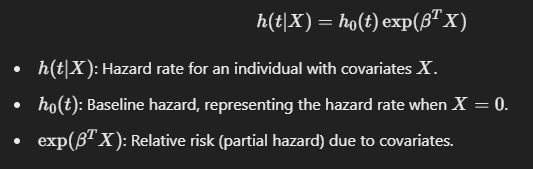
<br><b>Questions It Answers:</b>
1. How do specific factors (covariates) affect the risk of experiencing the event?
    - Example: How does age or usage frequency influence the risk of customer churn?
2. What is the relative risk between groups?
    - Example: How much more likely are high-usage customers to churn compared to low-usage customers?

### Data Preprocessing 

#### Drop Insignificant Features

In [38]:
survival_report['logrank_tests'].index[survival_report['logrank_tests']['p'] > 0.01]

Index(['Gender', 'PhoneService'], dtype='object')

In [39]:
df_clean = df.drop(columns=['Gender', 'PhoneService']).copy()

#### Custom Eencoding

In [40]:
categorical_features = [
    'InternetService', 'PaymentMethod', 'MultipleLines', 'Contract',
    'Partner', 'Dependents', 'PaperlessBilling',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

dropped_dummy_cols = [
    'InternetService_No', 'MultipleLines_No phone service', 'PaymentMethod_Electronic check', 'Contract_Month-to-month',
    'OnlineSecurity_No', 'OnlineBackup_No', 'DeviceProtection_No', 'TechSupport_No', 'StreamingTV_No', 'StreamingMovies_No',
    'Partner_No', 'Dependents_No', 'PaperlessBilling_No'
]
df_clean = pd.concat([df_clean, pd.get_dummies(df_clean[categorical_features])], axis=1)
df_clean = df_clean.drop(dropped_dummy_cols + categorical_features, axis=1)

# Drop No Internet Service (it is alyready presented by feature InternetService itself)
df_clean = df_clean[df_clean.columns[df_clean.columns.map(lambda x: 'No internet service' not in x)]]

#### Split Dataset

In [41]:
y = Surv.from_dataframe('Churn', 'Tenure', df_clean)
X = df_clean.drop(columns=['Churn', 'Tenure'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y['Churn'])
df_train, df_test = df_clean.loc[X_train.index, :], df_clean.loc[X_test.index, :]

In [42]:
for col_num in ['MonthlyCharges', 'TotalCharges']:
    new_col_num = f"Q_{col_num}"
    df_train[new_col_num], bins = pd.qcut(df_train[col_num], 4, duplicates='drop', retbins=True, labels=False)
    X_train[new_col_num] = pd.cut(X_train[col_num], bins=bins, labels=False, include_lowest=True)
    
    bins[0] = df[col_num].min()
    bins[-1] = df[col_num].max()
    
    df_test[new_col_num] = pd.cut(df_test[col_num], bins=bins, labels=False, include_lowest=True)    
    X_test[new_col_num] = pd.cut(X_test[col_num], bins=bins, labels=False, include_lowest=True)
    
    df_clean[new_col_num] = pd.cut(df_clean[col_num], bins=bins, labels=False, include_lowest=True)

#### Add Model Prediction (Optional: increase 2% scores)

In [43]:
model = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3)
model.fit(df_train.drop('Churn', axis=1), y_train['Churn'])
y_pred = model.predict(df_test.drop('Churn', axis=1))
print(f"Accuracy: {accuracy_score(y_test['Churn'], y_pred):.4f}")

df_clean['xgbc_proba'] = model.predict_proba(df_clean.drop(['Churn'], axis=1))[:, 1]
df_train['xgbc_proba'] = model.predict_proba(df_train.drop('Churn', axis=1))[:, 1]
df_test['xgbc_proba'] = model.predict_proba(df_test.drop('Churn', axis=1))[:, 1]
X_train['xgbc_proba'] = df_train['xgbc_proba'].copy()
X_test['xgbc_proba'] = df_test['xgbc_proba'].copy()

Accuracy: 0.7970


### Model Fitting

In [44]:
cph_base = CoxPHFitter()
cph_base.fit(df_train, 'Tenure', 'Churn')

<lifelines.CoxPHFitter: fitted with 4930 total observations, 3622 right-censored observations>

### Model Evaluation

In [45]:
risk_scores_train = cph_base.predict_partial_hazard(df_train)
risk_scores_test = cph_base.predict_partial_hazard(df_test)

print('C-Index-Train: ', cph_base.concordance_index_)
print('C-Index-Test: ', cph_base.score(df_test, 'concordance_index'))
print('C-IndexC-Train:', concordance_index_censored(df_train['Churn'], df_train['Tenure'], risk_scores_train)[0])
print('C-IndexC-Test:', concordance_index_censored(df_test['Churn'], df_test['Tenure'], risk_scores_test)[0])
print('AUCs-Train:', get_aucs_scores(cph_base, y_train, y_train, X_train, 'Tenure')[1])
print('AUCs-Test:', get_aucs_scores(cph_base, y_train, y_test, X_test, 'Tenure')[1])

C-Index-Train:  0.9625093980193818
C-Index-Test:  0.9523335425238236
C-IndexC-Train: 0.9625093980193818
C-IndexC-Test: 0.9523335425238236
AUCs-Train: 0.982600547261409
AUCs-Test: 0.9787652881979125


- The model exhibits high discrimination with a C-Index above 0.94, ensuring reliable ranking of survival probabilities.
- The C-IndexC (accounting for censoring) aligns with the standard C-Index, confirming minimal bias due to censored observations.
- The AUC values above 0.97 demonstrate strong distinction between risk levels.
- Slight test score reductions suggest minor overfitting but overall strong generalizability.

In [46]:
cph_base.summary.sort_values('coef', ascending=False).round(3)

coef    exp(coef)  se(coef)  \
covariate                                                                
xgbc_proba                               14.803  2685805.921     0.540   
InternetService_DSL                       2.320       10.177     0.712   
InternetService_Fiber optic               2.134        8.451     1.384   
MultipleLines_No                          1.989        7.310     0.559   
MultipleLines_Yes                         1.388        4.007     0.693   
OnlineSecurity_Yes                        0.769        2.157     0.161   
TechSupport_Yes                           0.680        1.975     0.160   
PaymentMethod_Mailed check                0.438        1.550     0.084   
StreamingTV_Yes                           0.319        1.375     0.282   
OnlineBackup_Yes                          0.299        1.348     0.153   
DeviceProtection_Yes                      0.297        1.346     0.150   
StreamingMovies_Yes                       0.282        1.325     0.280   
PaymentMethod_Credit card (automatic)     0.180        1.197     0.095   
Dependents_Yes                            0.131        1.140     0.086   
TotalCharges                             -0.000        1.000     0.000   
PaymentMethod_Bank transfer (automatic)  -0.001        0.999     0.089   
MonthlyCharges                           -0.053        0.949     0.028   
Q_MonthlyCharges                         -0.059        0.943     0.102   
Partner_Yes                              -0.100        0.904     0.066   
Contract_One year                        -0.238        0.789     0.137   
SeniorCitizen                            -0.299        0.741     0.069   
PaperlessBilling_Yes                     -0.797        0.451     0.083   
Q_TotalCharges                           -1.702        0.182     0.099   
Contract_Two year                        -2.332        0.097     0.238   

                                         coef lower 95%  coef upper 95%  \
covariate                                                                 
xgbc_proba                                       13.745          15.862   
InternetService_DSL                               0.925           3.716   
InternetService_Fiber optic                      -0.579           4.847   
MultipleLines_No                                  0.893           3.086   
MultipleLines_Yes                                 0.029           2.747   
OnlineSecurity_Yes                                0.454           1.084   
TechSupport_Yes                                   0.366           0.994   
PaymentMethod_Mailed check                        0.274           0.602   
StreamingTV_Yes                                  -0.233           0.871   
OnlineBackup_Yes                                 -0.000           0.598   
DeviceProtection_Yes                              0.003           0.591   
StreamingMovies_Yes                              -0.267           0.830   
PaymentMethod_Credit card (automatic)            -0.007           0.367   
Dependents_Yes                                   -0.038           0.300   
TotalCharges                                     -0.000           0.000   
PaymentMethod_Bank transfer (automatic)          -0.175           0.173   
MonthlyCharges                                   -0.107           0.001   
Q_MonthlyCharges                                 -0.259           0.141   
Partner_Yes                                      -0.230           0.030   
Contract_One year                                -0.505           0.030   
SeniorCitizen                                    -0.434          -0.164   
PaperlessBilling_Yes                             -0.960          -0.635   
Q_TotalCharges                                   -1.897          -1.508   
Contract_Two year                                -2.799          -1.865   

                                         exp(coef) lower 95%  \
covariate                                                      
xgbc_proba                             

- Since a churn event is represented by a value of True (1), a positive coefficient indicates a higher risk of churn.

In [47]:
insignificant_p_cols = cph_base.summary.index[cph_base.summary['p'] > 0.05]
insignificant_p_cols

Index(['MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)', 'Contract_One year',
       'Partner_Yes', 'Dependents_Yes', 'OnlineBackup_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Q_MonthlyCharges'],
      dtype='object', name='covariate')

In [48]:
insignificant_logp_cols = cph_base.summary.index[cph_base.summary['-log2(p)'] < 10]
insignificant_logp_cols

Index(['MonthlyCharges', 'TotalCharges', 'InternetService_DSL',
       'InternetService_Fiber optic',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)', 'MultipleLines_Yes',
       'Contract_One year', 'Partner_Yes', 'Dependents_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Q_MonthlyCharges'],
      dtype='object', name='covariate')

### Model Comparison

In [49]:
cph_report = HazardReport.cph_lifelines(df_clean, 'Churn', 'Tenure', 0.3)
cphsk_report = HazardReport.cph_sksurv(df_clean, 'Churn', 'Tenure', 0.3)
cph2_report = HazardReport.cph_lifelines(df_clean.drop(insignificant_p_cols, axis=1), 'Churn', 'Tenure', 0.3, 'cph2')
cphsk2_report = HazardReport.cph_sksurv(df_clean.drop(insignificant_p_cols, axis=1), 'Churn', 'Tenure', 0.3, 'cphsk2')
cph3_report = HazardReport.cph_lifelines(df_clean.drop(insignificant_logp_cols, axis=1), 'Churn', 'Tenure', 0.3, 'cph3')
cphsk3_report = HazardReport.cph_sksurv(df_clean.drop(insignificant_logp_cols, axis=1), 'Churn', 'Tenure', 0.3, 'cphsk3')

In [50]:
pd.concat([
    cph_report['scores'], cph2_report['scores'], cph3_report['scores'], 
    cphsk_report['scores'], cphsk2_report['scores'], cphsk3_report['scores']
], axis=1).style.highlight_max(axis=1, color='teal').highlight_min(axis=1, color='tomato')

### Model Visualization

In [51]:
cph = cph_report
cph['obj'].df = cph['df']['test']

cphsk = cphsk_report
cphsk['obj'].df = cphsk['df']['test']

#### Plot Features Coefficient

In [52]:
PlotlyHazard.plot_features_coefficient(cphsk['obj'], showlegend=False)

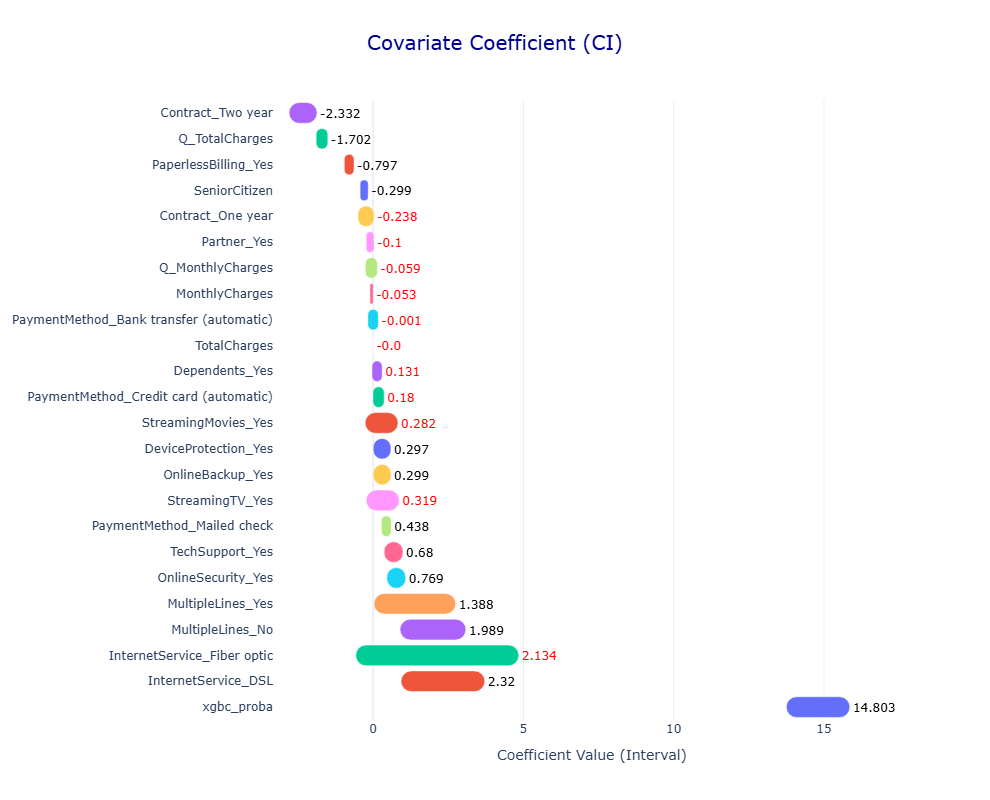

In [53]:
PlotlyHazard.plot_features_coefficient_ci(cph['obj'], showlegend=False)

#### Plot Partial Effects on Outcome

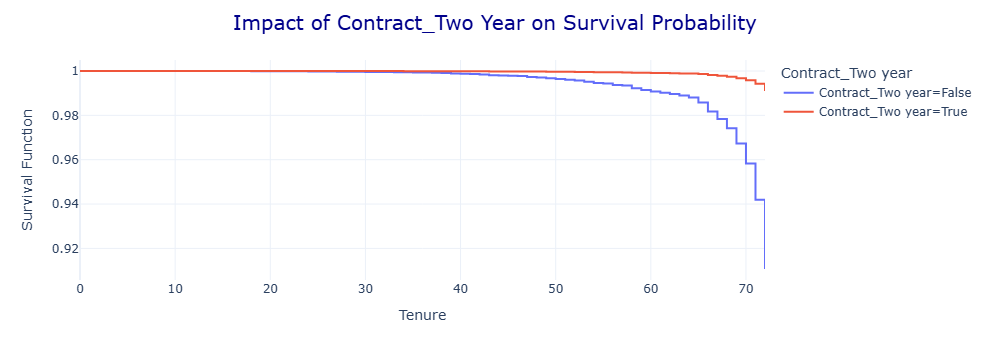

In [54]:
PlotlyHazard.plot_partial_effects_on_outcome(cph['obj'], 'Contract_Two year')

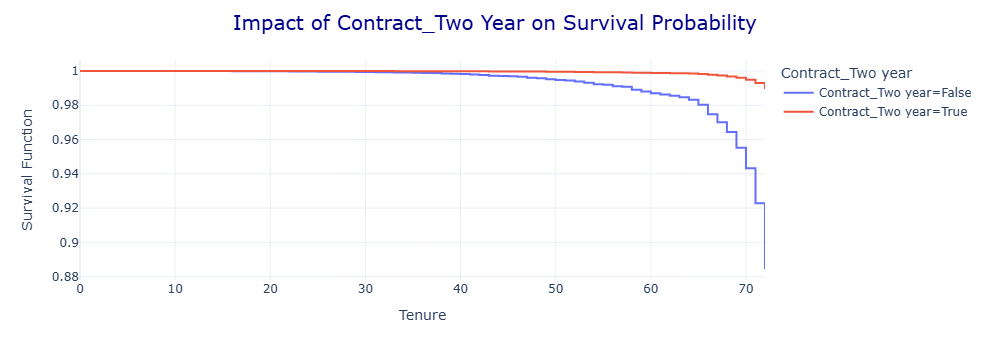

In [55]:
PlotlyHazard.plot_partial_effects_on_outcome(cphsk['obj'], 'Contract_Two year')

#### Plot Survival Time-Event

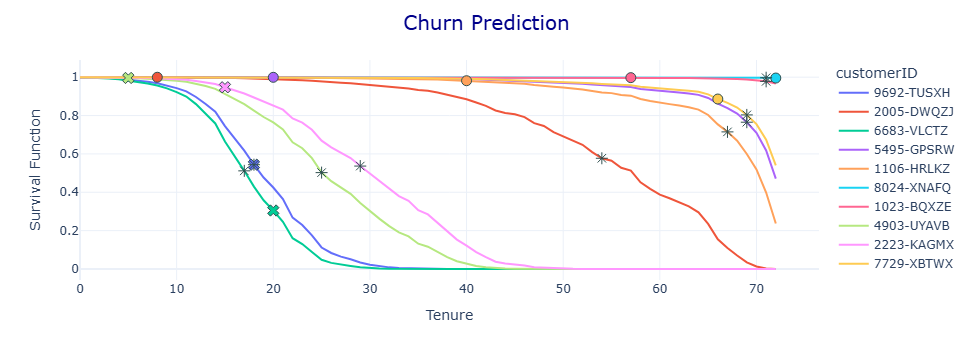

In [56]:
PlotlyHazard.plot_survival_time_event(cph['obj'], cph['obj'].df.index[:10], show_time_expectation=True)

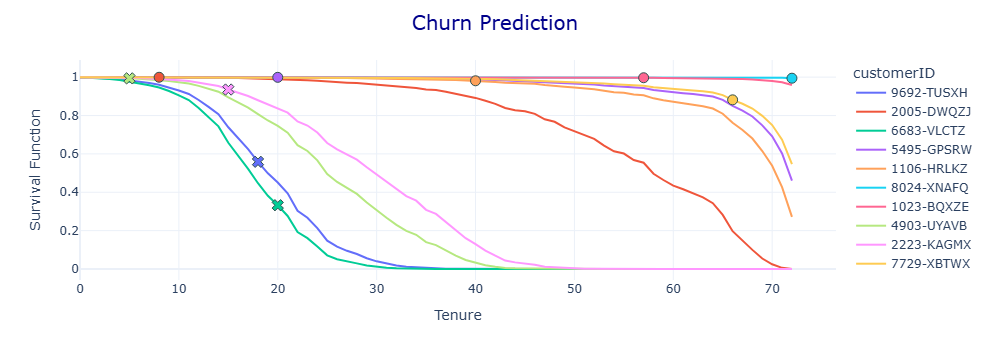

In [57]:
PlotlyHazard.plot_survival_time_event(cphsk['obj'], cphsk['obj'].df.index[:10], show_time_expectation=True)

#### Plot Survival Probability by Hazard-Based Quartile Grouping

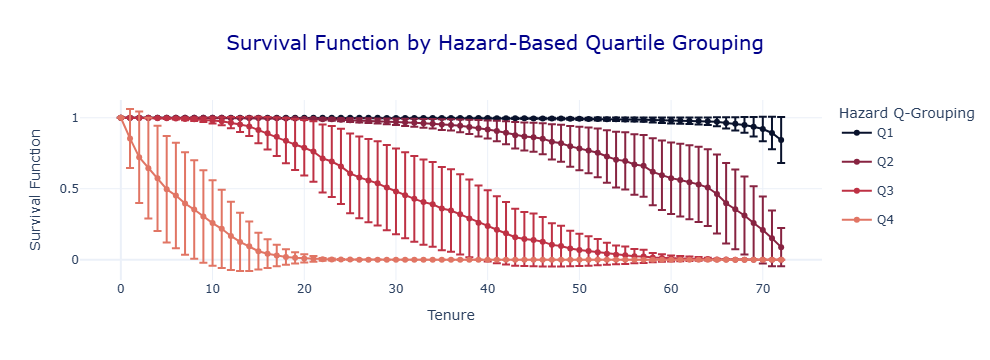

In [58]:
PlotlyHazard.plot_quartile_hazard_mean_survival(cph['obj'])

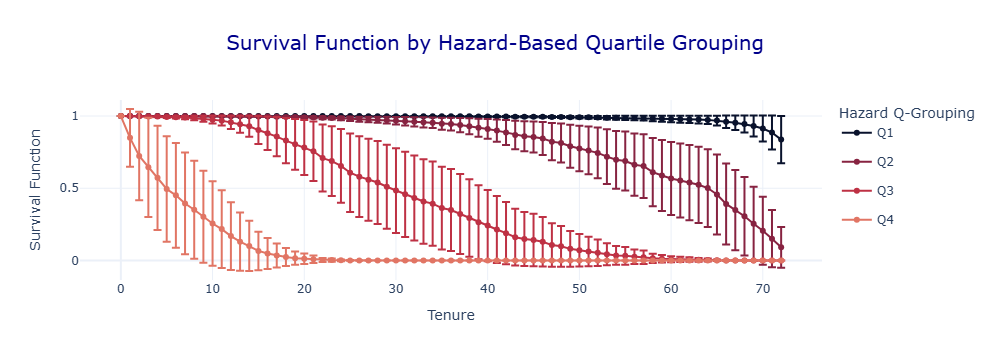

In [59]:
PlotlyHazard.plot_quartile_hazard_mean_survival(cphsk['obj'])

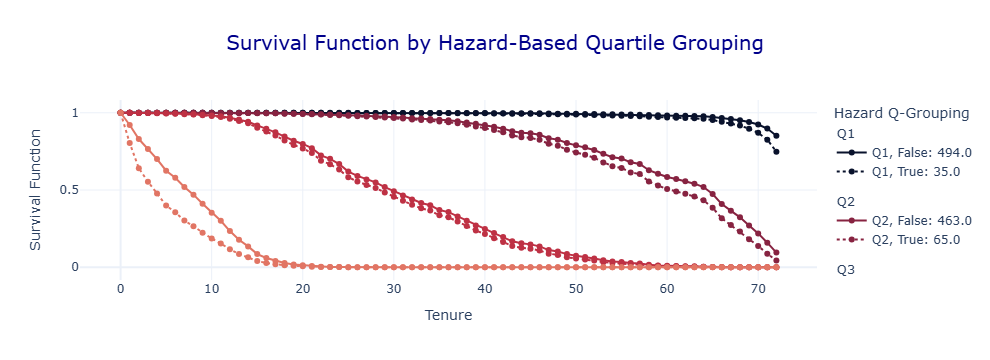

In [60]:
PlotlyHazard.plot_quartile_hazard_mean_survival_by_event(cph['obj'])

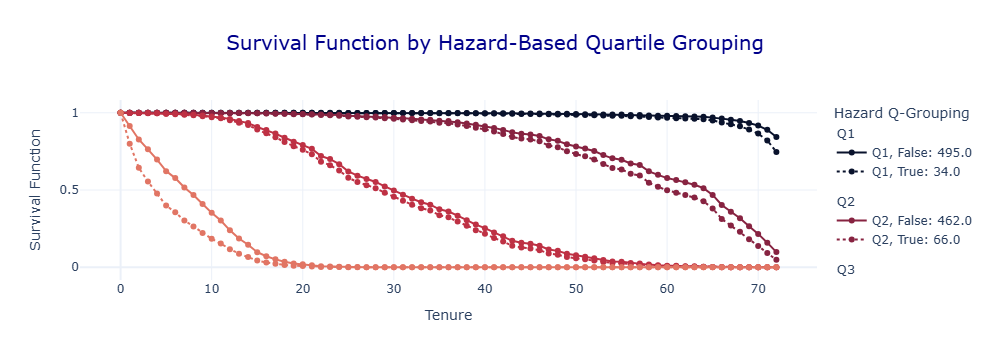

In [61]:
PlotlyHazard.plot_quartile_hazard_mean_survival_by_event(cphsk['obj'])

#### Plot AUCs Line

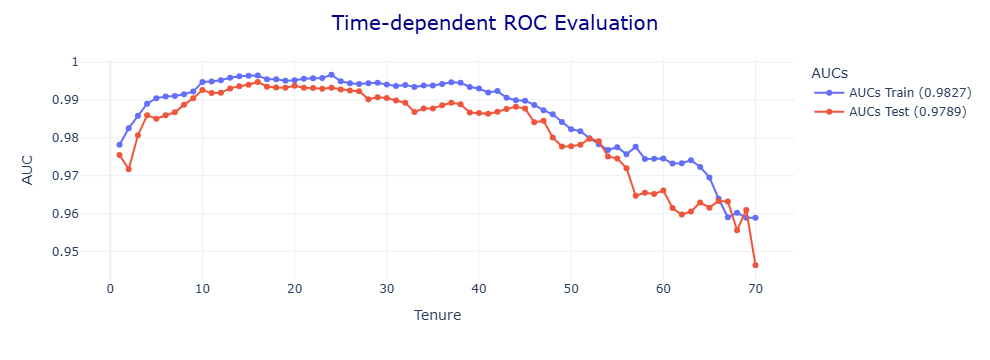

In [62]:
PlotlyHazard.plot_dynamic_auc_line(cphsk_report['times_auc'])